# K-Nearest Neighbor Lab





<a target="_blank" href="https://colab.research.google.com/github/dahenderson98/K-Nearest-Neighbors/blob/main/KNN.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

In [ ]:
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.model_selection import train_test_split
import numpy as np
import heapq
from scipy.io import arff
import matplotlib.pyplot as plt

## 1. Implement the k-nearest neighbor (KNN) algorithm

### Code requirements
- Use Euclidean distance to decide closest neighbors
- Implement both the regular (classifcation) version and the regression version
- Include optional distance weighting for both algorithms

In [ ]:
class KNNClassifier(BaseEstimator,ClassifierMixin):
    def __init__(self, columntype=[], mixed_types=False, weight_type='inverse_distance', algorithm="classification", k=3, normalize=False): 
        """
        Args:
            columntype for each column tells you if continuous[real] or if nominal[categoritcal].
            weight_type: inverse_distance voting or if non distance weighting. Options = ["no_weight","inverse_distance"]
            algorithm: calculate a nominal or continuous prediction model. Options = ["classification","regression"]
            k: number of nearest neighbors to consider when predicting a new instance's output. Options = [1, dataset.size]
        """
        self.columntype = columntype
        self.weight_type = weight_type
        self.algorithm = algorithm
        self.k = k
        self.normalize=normalize

    def fit(self, data, labels):
        """ Fit the data; run the algorithm (for this lab really just saves the data :D)
        Args:
            X (array-like): A 2D numpy array with the training data, excluding targets
            y (array-like): A 2D numpy array with the training targets
        Returns:
            self: this allows this to be chained, e.g. model.fit(X,y).predict(X_test)
        """
        data = self.set_floats(data)
        if self.normalize:
          data = self.normalize_data(data)
        if self.algorithm == "regression":
          labels = labels.astype(float)

        self.data = data
        self.labels = labels
        return self

    def set_floats(self, data):
      if len(self.columntype) == 0:
        data = data.astype(float)
      else:
        for i in range(data.shape[1]):
          if self.columntype[i] == 'c':
            data[:,i] = data[:,i].astype(float)
      return data

    def normalize_data(self, data):
      for col in range(data.shape[1]):
        if len(self.columntype) == 0 or self.columntype[col] == 'c':
          xmin, xmax = np.min(data[:,col].astype(float)), np.max(data[:,col].astype(float))
          _range = xmax-xmin
          data[:,col] = (data[:,col].astype(float) - xmin) / _range
      return data

    def get_euc_dist(self, p1, p2):
      return np.sqrt( np.sum( [ np.power((float(p1[i]) - float(p2[i])), 2) for i in range(len(p1)) ] ) )
    
    def predict(self, data):
        """ Predict all classes for a dataset X
        Args:
            X (array-like): A 2D numpy array with the training data, excluding targets
        Returns:
            array, shape (n_samples,)
                Predicted target values per element in X.
        """
        predictions = []

        
        for i in range(data.shape[0]):
          # Get Euclidian distances between new datapoint and all known datapoints
          if len(self.columntype) == 0: distances = np.linalg.norm(self.data - data[i], axis=1)
          # For data containing nominal features, represent differences in nominal data between intance and dataset as 0.5
          else:
            distances_list = []
            for j in range(self.data.shape[0]):
              sum = 0.0
              for k in range(self.data.shape[1]):
                if self.columntype[k] == 'c':
                  if self.data[j,k] == '?' or data[i,k] == '?': new_dist = 0.5
                  else: new_dist = self.data[j,k].astype(float) - data[i,k].astype(float)
                else:
                  new_dist = 0.0 if self.data[j,k] == data[i,k] else 0.5
                sum = sum + np.power(new_dist, 2)
              distances_list.append(np.sqrt(sum))
            distances = np.array(distances_list)

          #print("Distances:",distances)
          knn_indices = np.argsort(distances)[:self.k]
          # Create list with the k datapoints having the lowest Euclidian distance from the new datapoint (k nearest neighbors)
          knn = []
          # Create list of labels corresponding to datapoints with lowest Euclidian distances
          knn_targets = []
          # Create list of Euclidian distances corresponding to datapoints in nearest neighbors list above
          inverse_weights = []
          for j in knn_indices:
            knn.append(self.data[j])
            knn_targets.append(self.labels[j])
            inverse_weights.append(distances[j])

          if self.algorithm == "classification":
            output_options, vote_counts = np.unique(knn_targets, return_counts=True)
            # Predict new datapoint's output based on k nearest neighbors' outputs
            if self.weight_type == "inverse_distance":
              # If using distance weighting, scale output votes of k nearest neighbors and record the output with the highest vote factor
              # First, map outputs to vote_factors indices
              vote_factors = np.zeros(len(output_options))
              idx = [ j for j in range(len(output_options)) ]
              output_dict = {}
              for A, B in zip(output_options, idx):
                output_dict[A] = B
              for j in range(self.k):
                vote_factors[ output_dict[ knn_targets[j][0] ] ] += 1.0 / inverse_weights[j]
              prediction = output_options[ np.argmax(vote_factors) ]
            else:
              # If using non-distance weighting, record the output with the most votes from k nearest neighbors
              prediction = output_options[ np.argmax(vote_counts) ]
            # Append highest-voted output to predictions list as the prediction for this instance
            predictions.append(prediction)
          elif self.algorithm == "regression":
            output_options = np.array(np.unique(knn_targets)).astype(float)
            knn_outputs = []
            for j in range(len(knn_indices)):
              knn_outputs.append(self.labels[knn_indices[j]][0])
            knn_outputs = np.array(knn_outputs)
            # Predict new datapoint's output based on k nearest neighbors' outputs
            if self.weight_type == "inverse_distance":
              # If using distance weighting, record average output of k nearest neighbors, each scaled by their inverse distance
              weights_sq = np.array( [ np.power(distances[knn_indices[j]], 2) if distances[knn_indices[j]] != 0 else 0.001 for j in range(self.k) ] )
              prediction = np.dot(knn_outputs, 1.0/weights_sq) / np.sum(1.0/weights_sq)
            else:
              # If using non-distance weighting, record average output of k nearest neighbors
              prediction = np.sum(output_options) / self.k
            # Append highest-voted output to predictions list as the prediction for this instance
            predictions.append(prediction)

        return predictions

    # Returns the Mean score given input data and labels
    def score(self, X, y):
        """ Return accuracy of model on a given dataset. Must implement own score function.
        Args:
            X (array-like): A 2D numpy array with data, excluding targets
            y (array-like): A 2D numpy array with targets
        Returns:
            score : float
                Mean accuracy of self.predict(X) wrt. y.
        """
        # Ensure features of each data instance are in float form
        X = self.set_floats(X)
        # Normalize data, if specified
        if self.normalize: X = self.normalize_data(X)

        # Predict outputs of each instance in given dataset X
        predictions = self.predict(X)
        # Return accuracy if using the classification algorithm
        if self.algorithm == "classification":
          score = np.mean( [ 1 if predictions[i] == y[i] else 0 for i in range(len(predictions)) ] )
          return round(score, 4), predictions
        # Return Mean Squared Error if using the regression algorithm
        elif self.algorithm == "regression":
          y = y.astype(float)
          mse = np.mean( np.power(predictions - y, 2) )
          return mse, predictions
    

## Debug and Evaluation

Debug and Evaluate your model using the parameters below:
- Use distance weighting
- KNN = 3 (three nearest neighbors)
- Don’t normalize the data
- Use Euclidean Distance
---

### 1.1 (20%) Debug using this [training set](https://raw.githubusercontent.com/cs472ta/CS472/master/datasets/glass_train.arff) and this [test set](https://raw.githubusercontent.com/cs472ta/CS472/master/datasets/glass_test.arff)

Expected Results:
- Not using inverse weighted distancing = roughly [68.29%]
- Link to [debug solution](https://github.com/cs472ta/CS472/blob/master/debug_solutions/glass_no_inv_predictions.txt)
- Using inverse weighted distancing = roughly [74.39%]
- Link to [debug solution](https://github.com/cs472ta/CS472/blob/master/debug_solutions/glass_inv_predictions.txt)

In [ ]:
# Load glass data
# Training data
!curl -o debug_training_data.arff "https://raw.githubusercontent.com/cs472ta/CS472/master/datasets/glass_train.arff"
debug_training_data = np.array(arff.loadarff('debug_training_data.arff')[0].tolist())
X_debug_training, y_debug_training = debug_training_data[:,:-1], debug_training_data[:,-1].reshape(-1,1)

# Test data
!curl -o debug_test_data.arff "https://raw.githubusercontent.com/cs472ta/CS472/master/datasets/glass_test.arff"
debug_test_data = np.array(arff.loadarff('debug_test_data.arff')[0].tolist())
X_debug_test, y_debug_test = debug_test_data[:,:-1], debug_test_data[:,-1].reshape(-1,1)

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 12431  100 12431    0     0  64744      0 --:--:-- --:--:-- --:--:-- 64744
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5431  100  5431    0     0  42763      0 --:--:-- --:--:-- --:--:-- 42763


In [ ]:
# Train on training set (no distance weighting)
debug_knn = KNNClassifier(weight_type="no_weight", algorithm="classification", k=3)
_ = debug_knn.fit(X_debug_training, y_debug_training)

# Predict on test set (no distance weighting)
score, predictions = debug_knn.score(X_debug_test, y_debug_test)
print(f"Score w/o Distance Weighting: {score}")
#print(f"Predictions: {predictions}")

Score w/o Distance Weighting: 0.6829


In [ ]:
# Train on training set (with distance weighting)
debug_knn = KNNClassifier(weight_type="inverse_distance", algorithm="classification", k=3)
_ = debug_knn.fit(X_debug_training, y_debug_training)

# Predict on test set (no distance weighting)
score, predictions = debug_knn.score(X_debug_test, y_debug_test)
print(f"Score w Distance Weighting: {score}")
#print(f"Predictions: {predictions}")

Score w Distance Weighting: 0.7439


### 1.2 (20%) Evaluate

We will evaluate your model based on its performance on the [diabetes](https://archive.ics.uci.edu/ml/datasets/Diabetes) problem.
- Use this [training set](https://raw.githubusercontent.com/cs472ta/CS472/master/datasets/diabetes_train.arff) and this [test set](https://raw.githubusercontent.com/cs472ta/CS472/master/datasets/diabetes_test.arff) and have your code print the accuracy.

In [ ]:
# Load diabetes training data
!curl -o eval_training_data.arff "https://raw.githubusercontent.com/cs472ta/CS472/master/datasets/diabetes_train.arff"
eval_training_data = np.array(arff.loadarff('eval_training_data.arff')[0].tolist())
X_eval_training, y_eval_training = eval_training_data[:,:-1], eval_training_data[:,-1].reshape(-1,1)

# Load diabetes test data
!curl -o eval_test_data.arff "https://raw.githubusercontent.com/cs472ta/CS472/master/datasets/diabetes_test.arff"
eval_test_data = np.array(arff.loadarff('eval_test_data.arff')[0].tolist())
X_eval_test, y_eval_test = eval_test_data[:,:-1], eval_test_data[:,-1].reshape(-1,1)

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 37419  100 37419    0     0   264k      0 --:--:-- --:--:-- --:--:--  264k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 73698  100 73698    0     0   418k      0 --:--:-- --:--:-- --:--:--  418k


In [ ]:
# Train on training set (without distance weighting)
eval_knn = KNNClassifier(weight_type="no_weight", algorithm="classification", k=3)
eval_knn.fit(X_eval_training, y_eval_training)
# Predict on test set
score, predictions = eval_knn.score(X_eval_test, y_eval_test)
print(f"Score w/o Distance Weighting: {score}")
#print(f"Predictions: {predictions}")

Score w/o Distance Weighting: 0.8411


In [ ]:
# Train on training set (with distance weighting)
eval_knn = KNNClassifier(weight_type="inverse_distance", algorithm="classification", k=3)
eval_knn.fit(X_eval_training, y_eval_training)
# Predict on test set
score, predictions = eval_knn.score(X_eval_test, y_eval_test)
print(f"Score w Distance Weighting: {score}")
#print(f"Predictions: {predictions}")

Score w Distance Weighting: 0.8659


## 2. KNN with and without normalization

- Use the [magic telescope](http://archive.ics.uci.edu/ml/datasets/MAGIC+Gamma+Telescope) task with this [training set](https://raw.githubusercontent.com/cs472ta/CS472/master/datasets/magic_telescope_train.arff) and this [test set](https://raw.githubusercontent.com/cs472ta/CS472/master/datasets/magic_telescope_test.arff) 

### 2.1 (5%)
- Try it with k=3 and without distance weighting and *without* normalization


In [ ]:
# Load magic telescope training data
!curl -o magic_telescope_training.arff "https://raw.githubusercontent.com/cs472ta/CS472/master/datasets/magic_telescope_train.arff"
magic_telescope_training_data = np.array(arff.loadarff('magic_telescope_training.arff')[0].tolist())
X_magic_telescope_training, y_magic_telescope_training = magic_telescope_training_data[:,:-1], magic_telescope_training_data[:,-1].reshape(-1,1)

# Load magic telescope test data
!curl -o magic_telescope_test.arff "https://raw.githubusercontent.com/cs472ta/CS472/master/datasets/magic_telescope_test.arff"
magic_telescope_test_data = np.array(arff.loadarff('magic_telescope_test.arff')[0].tolist())
X_magic_telescope_test, y_magic_telescope_test = magic_telescope_test_data[:,:-1], magic_telescope_test_data[:,-1].reshape(-1,1)

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  937k  100  937k    0     0  3691k      0 --:--:-- --:--:-- --:--:-- 3691k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  505k  100  505k    0     0  2277k      0 --:--:-- --:--:-- --:--:-- 2267k


In [ ]:
telescope_knn = KNNClassifier(weight_type="no_weight", k=3, normalize=False)

# Train/Predict without normalization or distance weighting
_ = telescope_knn.fit(X_magic_telescope_training, y_magic_telescope_training)
score, predictions = telescope_knn.score(X_magic_telescope_test, y_magic_telescope_test) # Takes ~14 seconds to complete
print(f"Score w/o Normalization or Distance Weighting: {score}")
#print(f"Predictions: {predictions}")

Score w/o Normalization or Distance Weighting: 0.8083


### 2.2 (5%)
- Try it with k=3 without distance weighting and *with* normalization (input features normalized between 0 and 1). Use the normalization formula (x-xmin)/(xmax-xmin)

In [ ]:
telescope_knn = KNNClassifier(weight_type="no_weight", k=3, normalize=True)

# Train/Predict with normalization
_ = telescope_knn.fit(X_magic_telescope_training, y_magic_telescope_training)
score, predictions = telescope_knn.score(X_magic_telescope_test, y_magic_telescope_test)
print(f"Score w Normalization, w/o Distance Weighting: {score}")
#print(f"Predictions: {predictions}")

Score w Normalization, w/o Distance Weighting: 0.8158


*Discuss the results of using normalized data vs. unnormalized data*

Accuracy was 0.75 percentage points higher when using normalized data than when using non-normalized data. This is a small increase in accuracy on a 0-100 scale, but for a large dataset like the magic telescope dataset (~20,000 data instances), this accuracy boost yields a 150-instance increase in correct output class predictions.

### 2.3 (5%)

- Using your normalized data, create one graph with classification accuracy on the test set on the y-axis and k values on the x-axis. 
    - Use odd values of k from 1 to 15.
- As a rough sanity check, typical knn accuracies for the magic telescope data set are 75-85%

In [ ]:
# Train/Predict with normalization using k=1,3,...,15
kvals = []
accuracies = []
for i in range(1,16,2): # Takes ~ 2m5s to run
  kvals.append(i)
  trial_knn = KNNClassifier(weight_type="no_weight", k=i, normalize=True)
  _ = trial_knn.fit(X_magic_telescope_training, y_magic_telescope_training)
  _score, _ = trial_knn.score(X_magic_telescope_test, y_magic_telescope_test)
  accuracies.append(_score)

Accuracies: [0.7874, 0.8158, 0.8272, 0.8294, 0.8282, 0.8294, 0.8297, 0.8305]


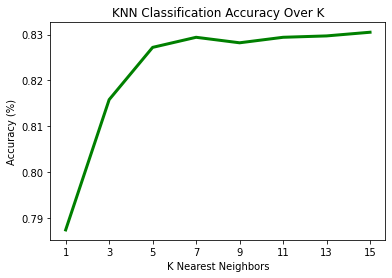

In [ ]:
# Graph classification accuracy over k
print("Accuracies:",accuracies)
plt.plot(kvals,accuracies, color="green", linewidth=3)
plt.title("KNN Classification Accuracy Over K")
plt.xlabel("K Nearest Neighbors")
plt.ylabel("Accuracy (%)")
plt.xticks(kvals)
plt.show()

*For the rest of the experiments use only normalized data*

## 3. (10%) KNN regression

- Use the regression variation of your algorithm (without distance weighting) on the [housing price prediction](https://www.cs.toronto.edu/~delve/data/boston/bostonDetail.html) problem.  Use this [training set](https://raw.githubusercontent.com/cs472ta/CS472/master/datasets/housing_train.arff) and this [test set](https://raw.githubusercontent.com/cs472ta/CS472/master/datasets/housing_test.arff). Note this data set has an example of an inappropriate use of data which we will discuss.
- Use Mean Square Error (MSE) on the test set as your accuracy metric for this case
    - Do not normalize regression output values
- Graph MSE on the test set with odd values of k from 1 to 15

In [ ]:
# Load housing price prediction data
# Training data
!curl -o housing_training_data.arff "https://raw.githubusercontent.com/cs472ta/CS472/master/datasets/housing_train.arff"
housing_training_data = np.array(arff.loadarff('housing_training_data.arff')[0].tolist())
X_housing_training, y_housing_training = housing_training_data[:,:-1], housing_training_data[:,-1].reshape(-1,1)

# Test data
!curl -o housing_test_data.arff "https://raw.githubusercontent.com/cs472ta/CS472/master/datasets/housing_test.arff"
housing_test_data = np.array(arff.loadarff('housing_test_data.arff')[0].tolist())
X_housing_test, y_housing_test = housing_test_data[:,:-1], housing_test_data[:,-1].reshape(-1,1)

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 34205  100 34205    0     0   191k      0 --:--:-- --:--:-- --:--:--  191k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  3885  100  3885    0     0  24433      0 --:--:-- --:--:-- --:--:-- 24433


In [ ]:
# Train/Predict using k=1,3,...,15
kvals = []
mse_vals = []
for i in range(1,16,2):
  kvals.append(i)
  trial_knn = KNNClassifier(algorithm="regression", weight_type="no_weight", k=i, normalize=True)
  _ = trial_knn.fit(X_housing_training, y_housing_training)
  mse, _ = trial_knn.score(X_housing_test, y_housing_test)
  mse_vals.append(mse)

MSE's: [175.849261822376, 142.21523644752017, 128.49972748942713, 123.32240613892617, 121.28288208238996, 120.80819932575201, 118.9695234195314, 119.36559164423937]


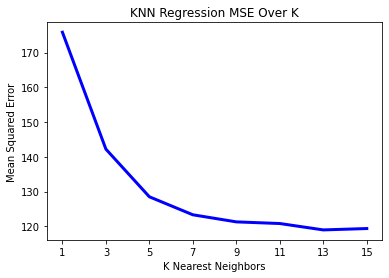

In [ ]:
# Graph MSE over k
print("MSE's:",mse_vals)
plt.plot(kvals,mse_vals, color="blue", linewidth=3)
plt.title("KNN Regression MSE Over K")
plt.xlabel("K Nearest Neighbors")
plt.ylabel("Mean Squared Error")
plt.xticks(kvals)
plt.show()

## 4. KNN with distance weighting
- Repeat your experiments for magic telescope and housing using distance-weighted (inverse of distance squared) voting and discuss your results.

### 4.1 (7.5%) Magic Telescope Dataset

In [ ]:
# Train/Predict magic telescope using distance-weighted voting
kvals = []
accuracies = []
for i in range(1,16,2): #Takes ~2m10s to run
  kvals.append(i)
  trial_knn = KNNClassifier(weight_type="inverse_distance", k=i, normalize=True)
  _ = trial_knn.fit(X_magic_telescope_training, y_magic_telescope_training)
  _score, _ = trial_knn.score(X_magic_telescope_test, y_magic_telescope_test)
  accuracies.append(_score)

Accuracies: [0.7874, 0.8158, 0.8275, 0.8291, 0.8285, 0.8294, 0.8302, 0.8305]


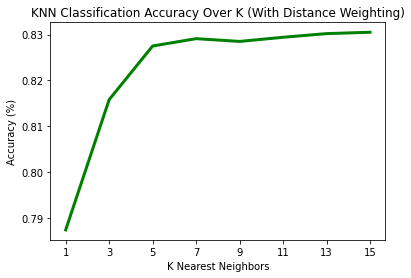

In [ ]:
# Graph classification accuracy over k
print("Accuracies:",accuracies)
plt.plot(kvals,accuracies, color="green", linewidth=3)
plt.title("KNN Classification Accuracy Over K (With Distance Weighting)")
plt.xlabel("K Nearest Neighbors")
plt.ylabel("Accuracy (%)")
plt.xticks(kvals)
plt.show()

### 4.2 (7.5%) Housing Dataset

In [ ]:
# Train/Predict housing using distance-weighted voting
kvals = []
weighted_mse_vals = []
for i in range(1,16,2):
  kvals.append(i)
  trial_knn = KNNClassifier(algorithm="regression", weight_type="inverse_distance", k=i, normalize=True)
  _ = trial_knn.fit(X_housing_training, y_housing_training)
  mse, _ = trial_knn.score(X_housing_test, y_housing_test)
  weighted_mse_vals.append(mse)

MSE's: [175.849261822376, 154.6436859017381, 138.82844439723186, 137.59873363076508, 135.8424157273118, 133.78408821040173, 130.63721724635167, 129.25859008288157]


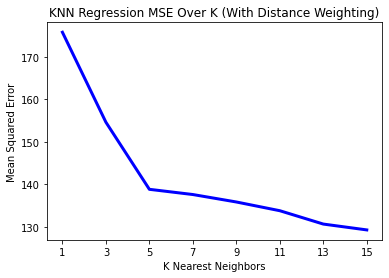

In [ ]:
# Graph MSE over k
print("MSE's:",weighted_mse_vals)
plt.plot(kvals,weighted_mse_vals, color="blue", linewidth=3)
plt.title("KNN Regression MSE Over K (With Distance Weighting)")
plt.xlabel("K Nearest Neighbors")
plt.ylabel("Mean Squared Error")
plt.xticks(kvals)
plt.show()

*Discuss your results*

## 5. (10%) KNN with nominal and unknown data

- Use the [credit-approval](https://archive.ics.uci.edu/ml/datasets/Credit+Approval) task and this [dataset](https://raw.githubusercontent.com/cs472ta/CS472/master/datasets/credit_approval.arff)
    - Use a 70/30 split of the data for the training/test set
- Note that this set has both continuous and nominal attributes, together with don’t know values. 
- Implement and justify a distance metric which supports continuous, nominal, and don’t know attribute values
    - You need to handle don't knows with the distance metric, not by imputing a value.
    - More information on distance metrics can be found [here](https://www.jair.org/index.php/jair/article/view/10182/24168).
- Use your own choice for k.
- As a rough sanity check, typical knn accuracies for the credit data set are 70-80%.

In [ ]:
# Load dataset and split into train/test sets
!curl -o credit_data.arff "https://raw.githubusercontent.com/cs472ta/CS472/master/datasets/credit_approval.arff"
credit_data = np.array(arff.loadarff('credit_data.arff')[0].tolist())
X_credit, y_credit = credit_data[:,:-1], credit_data[:,-1].reshape(-1,1)
X_credit_training, X_credit_test, y_credit_training, y_credit_test = train_test_split(X_credit, y_credit, test_size=0.3, shuffle=True)

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 34315  100 34315    0     0   186k      0 --:--:-- --:--:-- --:--:--  187k


In [ ]:
# Train/Predict credit-approval
credit_knn = KNNClassifier(algorithm="classification", weight_type="inverse_distance", k=7, normalize=True, 
                           columntype=['n','c','c','n','n','n','n','c','n','n','c','n','n','c','c'])
_ = credit_knn.fit(X_credit_training, y_credit_training)
score, predictions = credit_knn.score(X_credit_test, y_credit_test)
print(f"Score: {score}")

Score: 0.4831


*Explain and justify your distance metric and discuss your results*

My distance metric sets the distance between non-matching nominal data features as 0.5. It also counts the difference between a '?' value and any other value (nominal or continuous) as 0.5, as well. There may still be a bug in this part of my algorithm, as the accuracy it yields is pretty poor, but I have run out of time to finish debugging it.

## 6. (10%) Scikit-Learn KNN 
- Use the scikit-learn KNN version on magic telescope and housing and compare your results
- Try out different hyperparameters to see how well you can do. 

In [ ]:
# Train/Predict magic telescope using scikit's KNN
skl_knn = KNeighborsClassifier(n_neighbors=15, weights='distance',n_jobs=-1)
_ = skl_knn.fit(X_magic_telescope_training, y_magic_telescope_training)
score = skl_knn.score(X_magic_telescope_test, y_magic_telescope_test)
print("Magic Telescope Score (Accuracy):",score)
# Train/Predict housing using scikit's KNN
skl_knn = KNeighborsRegressor(n_neighbors=17, weights='uniform',n_jobs=-1)
_ = skl_knn.fit(X_housing_training.astype(float), y_housing_training.astype(float))
score = skl_knn.score(X_housing_test.astype(float), y_housing_test.astype(float))
print("Housing Score (R^2):",score)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:976: FutureWarning: Arrays of bytes/strings is being converted to decimal numbers if dtype='numeric'. This behavior is deprecated in 0.24 and will be removed in 1.1 (renaming of 0.26). Please convert your data to numeric values explicitly instead.
  estimator=estimator,
/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:566: FutureWarning: Arrays of bytes/strings is being converted to decimal numbers if dtype='numeric'. This behavior is deprecated in 0.24 and will be removed in 1.1 (renaming of 0.26). Please convert your data to numeric values explicitly instead.
  X = check_array(X, **check_params)


Magic Telescope Score (Accuracy): 0.8244824482448245
Housing Score (R^2): 0.42822888333616493


*Report your comparison*

Using the scikit learn knn package for classification on the magic telescope task, I achieved about a 1-percentage-point improvement over using my own model (~82% vs ~81%). Optimal hyperparameters for this one turned out to be a k-value of 15 and using inverse distance weighting. The scikit learn knn package for regression performed quite poorly on the housing task, only achieving an R^2 value of around ~0.43. I belive my regression model performed better than the scikit learn model on this task. Optimal hyperparameters that I found for this task were a k-value of 17 and no distance weighting.

## 7. (optional 5% extra credit): Reducing the data set
- Choose either of the data sets above and use the best k value you found.
- Implement a reduction algorithm that removes data points in some rational way such that performance does not drop too drastically on the test set given the reduced training set.
- Compare your performance on the test set for the reduced and non-reduced versions and give the number (and percentage) of training examples removed from the original training set. 
    - Note that performance for magic telescope is classification accuracy and for housing it is mean squared error.
    - Magic Telescope has about 12,000 instances and if you use a leave one out style of testing for your data set reduction, then your algorithm will run slow since that is n^2 at each step.
        - If you wish, you may use a random subset of 2,000 of the magic telescope instances.
    - More information on reduction techniques can be found [here](http://axon.cs.byu.edu/~martinez/classes/478/slides/IBL.pdf).

In [ ]:
# Code here

Discussion. How well did it do?